In [21]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.python.keras.applications.vgg19 import VGG19

In [22]:
#since we dont want the output of this model but only some intermediate layers we set include_top=False
model=VGG19(
    include_top = False,
    weights = 'imagenet'
)

#Also since we dont want the model to update the parameters as we run it
model.trainable = False
model.summary()
#vgg19 has 5 blocks and each block has a few convolutional layers followed by a pooling layer

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [23]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
#our model expects a 4 dimensional tensor hence np.expand_dims(img,axis=0)
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img


In [25]:
#this deprocess is done to reverse the effects of preprocess_input
def deprocess(x):
    x[:,:,0]+=103.939
    x[:,:,1]+=116.779
    x[:,:,2]+=123.68
    x=x[:,:,::-1]
    
    x=np.clip(x,0,255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img =np.squeeze(image, axis = 0)
    img = deprocess(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

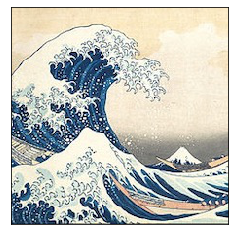

In [45]:
display_image(load_and_process_image('style.jpg'))

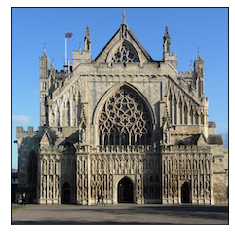

In [8]:
display_image(load_and_process_image('content.jpg'))

In [28]:
#content and style models
#the complex features are recognised in the conv2 layer of block 5 in vgg19 mainly
#here we are only using 3 in style_layers but most egs will use 5 
content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input,
                     outputs = model.get_layer(layer).output) for layer in style_layers]


In [29]:
#finding content cost
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C-a_G))
    return cost

In [30]:
#gram matrix to compute the style cost
#we compute gram matrix for the activation of the style and generated image- it gives us a strong feature correlation
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A,[-1, n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a=True)
    return G/tf.cast(n,tf.float32)

In [31]:
#finding style cost as weighted sum of each of the models
lam = 1./len(style_models)
def style_cost(style, generated):
    J_style = 0
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS-GG))
        J_style += current_cost*lam
    return J_style


In [42]:
#training loop
#alpha and beta are the weights used to compute the cost- alpha for content image and beta for style image
import time 
generated_images = []
def training_loop(content_path,style_path,iterations=20,alpha=10.,beta=20.):
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.contrib.eager.Variable(content, dtype = tf.float32)
    opt=tf.train.AdamOptimizer(learning_rate = 7.)
    best_cost = 1e12 + 0.1
    best_image = None 
    start_time = time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = alpha*J_content + beta*J_style
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
            
        print('Cost at {}: {}. Time elapsed: {}'.format(i,J_total, time.time()-start_time))
        generated_images.append(generated.numpy())
        
    return best_image

In [43]:
best_image = training_loop('content.jpg', 'style.jpg')

Cost at 0: 13733986304.0. Time elapsed: 4.571766138076782
Cost at 1: 8505726976.0. Time elapsed: 8.805438041687012
Cost at 2: 5336611840.0. Time elapsed: 12.986250877380371
Cost at 3: 4128449280.0. Time elapsed: 17.142130613327026
Cost at 4: 3317495040.0. Time elapsed: 21.303994178771973
Cost at 5: 2789856768.0. Time elapsed: 25.462865352630615
Cost at 6: 2499662848.0. Time elapsed: 29.57386541366577
Cost at 7: 2264955136.0. Time elapsed: 33.813520431518555
Cost at 8: 2034292608.0. Time elapsed: 38.04619336128235
Cost at 9: 1824851584.0. Time elapsed: 42.237977027893066
Cost at 10: 1641300096.0. Time elapsed: 46.39285969734192
Cost at 11: 1471981696.0. Time elapsed: 50.52879190444946
Cost at 12: 1319607552.0. Time elapsed: 54.62782406806946
Cost at 13: 1195674624.0. Time elapsed: 58.826592445373535
Cost at 14: 1100264576.0. Time elapsed: 63.00341200828552
Cost at 15: 1022310912.0. Time elapsed: 67.14632606506348
Cost at 16: 955013120.0. Time elapsed: 71.30220556259155
Cost at 17: 89365

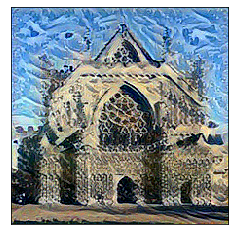

In [44]:
display_image(best_image)

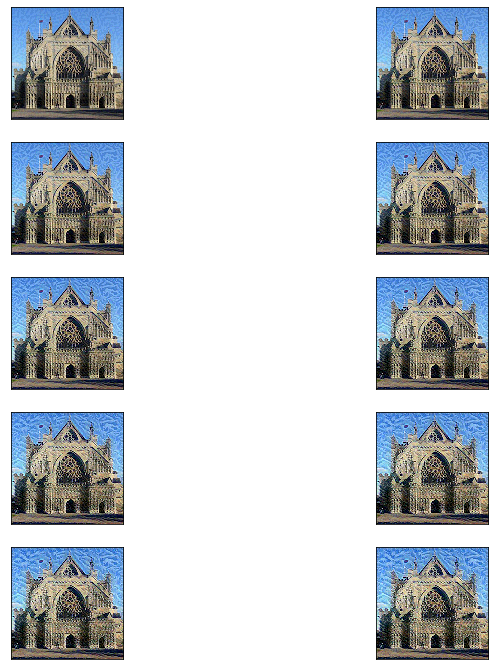

In [46]:
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    display_image(generated_images[i])
plt.show()